In [1]:
# Wikipedia Editor Conflict Analysis
# Enhanced with Aggressiveness & Pro-Israel/Palestine Bias Detection

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import re
import joblib
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from datetime import datetime
import mwclient

# Initialize NLTK components
try:
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmetizer()
except:
    import nltk
    nltk.download('stopwords')
    nltk.download('wordnet')
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\USER/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
import re
import time
import json
import os
import pandas as pd
import mwclient
from tqdm import tqdm
from datetime import timedelta, datetime
from urllib.parse import unquote
import concurrent.futures
from concurrent.futures import ThreadPoolExecutor

# BIAS ANALYSIS

# Load your bias model
bias_model = joblib.load('models/israel_palestine_bias_model.pkl')

def preprocess_for_bias(text):
    """Preprocess text for bias classification"""
    if not isinstance(text, str):
        return ""
    text = text.lower().strip()
    text = re.sub(r'http\S+|www\S+|@\w+|[^a-zA-Z\s]', '', text)
    return text

def predict_bias(text):
    """Predict pro-Israel/pro-Palestine bias"""
    processed = preprocess_for_bias(text)
    if not processed:
        return "neutral"
    try:
        return bias_model.predict([processed])[0]
    except:
        return "neutral"

In [3]:
class WikipediaRevisionCrawler:
    def __init__(self, max_depth=2, max_pages=50, revisions_per_page=500, request_delay=0.5,
                 bot_cache_file='bot_users.json', non_bot_cache_file='non_bot_users.json',
                 max_workers=4):
        self.site = mwclient.Site('en.wikipedia.org')
        self.max_depth = max_depth
        self.max_pages = max_pages
        self.revisions_per_page = revisions_per_page
        self.request_delay = request_delay
        self.visited_pages = set()
        self.all_data = []
        self.start_time = None
        self.crawled_pages = 0
        self.max_workers = max_workers

        # Bot and non-bot caches
        self.bot_users = set()
        self.non_bot_users = set()
        self.bot_cache_file = bot_cache_file
        self.non_bot_cache_file = non_bot_cache_file

        # Keywords for Israel/Palestine relevance
        self.relevance_keywords = {
            'israel', 'palestin', 'gaza', 'west bank', 'hamas', 'fatah', 'hezbollah',
            'netanyahu', 'jerusalem', 'tel aviv', 'idf', 'plo', 'palestinian authority',
            'settlement', 'occupation', 'nakba', 'intifada', 'al-aqsa', 'temple mount',
            'oslo', 'peace process', 'six-day war', 'yom kippur war', '1948 war',
            'balfour', 'mandate', 'zion', 'jewish state', 'right of return'
        }

        self.load_bot_caches()

    def load_bot_caches(self):
        """Load bot and non-bot caches from disk."""
        if os.path.exists(self.bot_cache_file):
            with open(self.bot_cache_file, 'r') as f:
                self.bot_users = set(json.load(f))
            print(f"Loaded {len(self.bot_users)} known bot users from cache.")

        if os.path.exists(self.non_bot_cache_file):
            with open(self.non_bot_cache_file, 'r') as f:
                self.non_bot_users = set(json.load(f))
            print(f"Loaded {len(self.non_bot_users)} known non-bot users from cache.")

    def save_bot_caches(self):
        """Save bot and non-bot caches to disk."""
        with open(self.bot_cache_file, 'w') as f:
            json.dump(sorted(self.bot_users), f)
        with open(self.non_bot_cache_file, 'w') as f:
            json.dump(sorted(self.non_bot_users), f)
        print(f"Saved {len(self.bot_users)} bots and {len(self.non_bot_users)} non-bots to cache.")

    def preload_bots(self):
        """Preload bot users via API to populate cache faster."""
        print("Preloading list of known bots from API...")
        aicontinue = ''
        while True:
            try:
                response = self.site.api('query', list='allusers', augroup='bot', aulimit='500',
                                         **({'aufrom': aicontinue} if aicontinue else {}))
                bots = [user['name'] for user in response.get('query', {}).get('allusers', [])]
                self.bot_users.update(bots)
                if 'continue' in response:
                    aicontinue = response['continue']['aufrom']
                else:
                    break
            except Exception as e:
                print(f"Failed to preload bots: {e}")
                break
        print(f"Added {len(self.bot_users)} bots from preload.")

    def batch_check_bot_users(self, usernames):
        """Check multiple users at once for bot status with chunking."""
        results = {}
        to_check = []
        
        # First check caches
        for user in usernames:
            if not user:
                results[user] = False
            elif user in self.bot_users:
                results[user] = True
            elif user in self.non_bot_users:
                results[user] = False
            else:
                to_check.append(user)
        
        # Process users in chunks of 50 (API limit)
        chunk_size = 50
        for i in range(0, len(to_check), chunk_size):
            chunk = to_check[i:i + chunk_size]
            try:
                response = self.site.api('query', 
                                    list='users',
                                    ususers='|'.join(chunk),
                                    usprop='groups',
                                    api_chunk_size=chunk_size)
                
                for user in response.get('query', {}).get('users', []):
                    name = user.get('name')
                    groups = user.get('groups', [])
                    is_bot = 'bot' in groups
                    results[name] = is_bot
                    if is_bot:
                        self.bot_users.add(name)
                    else:
                        self.non_bot_users.add(name)
                
                # Handle any users not returned by API
                for user in chunk:
                    if user not in results:
                        results[user] = False
                        self.non_bot_users.add(user)
                        
            except Exception as e:
                print(f"Error checking user chunk: {e}")
                for user in chunk:
                    results[user] = False
                    self.non_bot_users.add(user)
        
        return results

    def is_bot_user(self, username):
        """Check single user (wrapper around batch check)."""
        if not username:
            return False
        return self.batch_check_bot_users([username]).get(username, False)

    def get_links_from_page(self, page_title):
        try:
            page = self.site.pages[page_title]
            if not page.exists:
                return []
            return [unquote(link.name) for link in page.links()]
        except Exception as e:
            print(f"Error getting links from {page_title}: {e}")
            return []

    def parse_struct_time(self, value):
        """Extract date fields from the struct_time-like string."""
        if not value:
            return None

        try:
            match = re.search(r'tm_year=(\d+), tm_mon=(\d+), tm_mday=(\d+), tm_hour=(\d+), tm_min=(\d+), tm_sec=(\d+)', value)
            if match:
                year, month, day, hour, minute, second = map(int, match.groups())
                return datetime(year, month, day, hour, minute, second)
        except (ValueError, TypeError) as e:
            print(f"Error parsing timestamp {value}: {e}")
        return None

    def is_relevant_to_israel_palestine(self, page_title, page_content=None):
        """More strict relevance check"""
        lower_title = page_title.lower()
            
        # Required primary keywords
        primary_terms = {'israel', 'palestin', 'gaza', 'west bank', 'judea', 'samaria', 
                        'hamas', 'idf', 'plo', 'jerusalem', 'tel aviv', 'hebron'}
            
        secondary_terms = {'conflict', 'war', 'settlement', 'occupation', 'peace', 
                        'arab', 'jew', 'muslim', 'coexistence'}
        secondary_matches = sum(term in lower_title for term in secondary_terms)
        
        return secondary_matches >= 2 or any(term in lower_title for term in primary_terms)

    def process_revision_bias(self, revision):
        # Expanded set of relevant terms (including common misspellings and related terms)
        relevant_comments = {
            'israel', 'israeli', 'palestin', 'palestine', 'palestinian',
            'gaza', 'west bank', 'judea', 'samaria', 'hamas', 'fatah',
            'idf', 'jerusalem', 'tel aviv', 'hebron', 'nakba',
            'settlement', 'occupation', 'two state', 'peace process'
        }
        
        comment = revision.get('comment', '').lower()
        
        bias = predict_bias(comment)
        # Check if any term appears as a whole word (more precise)
        if bias == 'neutral' and not any(f' {term} ' in f' {comment} ' for term in relevant_comments):
            return "neutral"
        
        # If we get here, it's a relevant edit
        return bias

    def fetch_page_revisions(self, page_title):
        try:
            page = self.site.pages[page_title]
            if not page.exists:
                print(f"Warning: Page '{page_title}' does not exist")
                return []

            # First check if page is relevant
            if not self.is_relevant_to_israel_palestine(page_title):
                return []

            revisions_data = []
            users_to_check = set()
            revisions = []
            
            # First collect all revisions and users
            for revision in page.revisions(prop='ids|timestamp|user|comment|size', 
                                        api_chunk_size=self.revisions_per_page):
                user = revision.get('user', '').strip()
                bias = self.process_revision_bias(revision)
                if user:  # Skip empty usernames
                    users_to_check.add(user)
                    
                if bias != "neutral":
                    revisions.append((revision, bias))
                    if len(revisions) >= self.revisions_per_page:
                        break  # Stop when we reach our desired count
                
            # Batch check all users at once
            if users_to_check:
                bot_status = self.batch_check_bot_users(users_to_check)
            
            # Process revisions after we know bot status
            for revision, bias in revisions:
                user = revision.get('user', '').strip()
                if user and bot_status.get(user, False):
                    continue
                
                revisions_data.append({
                    'page': page_title,
                    'user': user,
                    'timestamp': self.parse_struct_time(str(revision.get('timestamp'))),
                    'comment': revision.get('comment', '').strip(),
                    'size': revision.get('size'),
                    'revid': revision.get('revid'),
                    'is_bot': False,
                    'bias': bias
                })

            time.sleep(self.request_delay)
            self.crawled_pages += 1
            return revisions_data

        except Exception as e:
            print(f"Error fetching page {page_title}: {e}")
            return []

    def is_relevant_page(self, page_title):
        """Check if page should be included in crawl."""
        # Skip disambiguation pages, categories, etc.
        if ":" in page_title or "disambiguation" in page_title.lower():
            return False
            
        # Check if page is relevant to our topic
        return self.is_relevant_to_israel_palestine(page_title)

    def get_time_estimate(self):
        if not self.start_time or self.crawled_pages == 0:
            return "Estimating..."
        elapsed = time.time() - self.start_time
        pages_remaining = self.max_pages - self.crawled_pages
        time_per_page = elapsed / self.crawled_pages
        return str(timedelta(seconds=int(pages_remaining * time_per_page)))

    def process_page(self, page_title):
        """Process a single page (for parallel execution)."""
        if len(self.visited_pages) >= self.max_pages:
            return []

        if page_title in self.visited_pages:
            return []

        self.visited_pages.add(page_title)
        revisions = self.fetch_page_revisions(page_title)
        return revisions

    def recursive_crawl(self, seed_pages, current_depth=0):
        if current_depth > self.max_depth or len(self.visited_pages) >= self.max_pages:
            return

        new_pages = [p for p in seed_pages if p not in self.visited_pages][:self.max_pages - len(self.visited_pages)]
        
        with tqdm(total=len(new_pages), desc=f"Depth {current_depth}") as pbar:
            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                futures = []
                for page_title in new_pages:
                    if len(self.visited_pages) >= self.max_pages:
                        break
                    futures.append(executor.submit(self.process_page, page_title))

                for future in concurrent.futures.as_completed(futures):
                    revisions = future.result()
                    self.all_data.extend(revisions)
                    pbar.update(1)
                    pbar.set_postfix({
                        'visited': f"{len(self.visited_pages)}/{self.max_pages}",
                        'remaining': self.get_time_estimate(),
                        'revisions': len(self.all_data),
                        'bots_known': len(self.bot_users)
                    })

        # Get links for next depth level
        if current_depth < self.max_depth:
            linked_pages = []
            with ThreadPoolExecutor(max_workers=self.max_workers) as executor:
                link_futures = {executor.submit(self.get_links_from_page, page): page for page in self.visited_pages}
                for future in concurrent.futures.as_completed(link_futures):
                    page = link_futures[future]
                    try:
                        links = future.result()
                        linked_pages.extend([p for p in links if self.is_relevant_page(p) and p not in self.visited_pages])
                    except Exception as e:
                        print(f"Error getting links for {page}: {e}")

            # Remove duplicates while preserving order
            seen = set()
            linked_pages = [p for p in linked_pages if not (p in seen or seen.add(p))]
            self.recursive_crawl(linked_pages, current_depth + 1)

    def crawl(self, seed_pages):
        self.start_time = time.time()
        self.preload_bots()
        self.recursive_crawl(seed_pages)
        self.save_bot_caches()
        df = pd.DataFrame(self.all_data)
        if not df.empty:
            df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
        return df


# --- Configuration and Run ---
config = {
    'max_depth': 2,
    'max_pages': 300,
    'revisions_per_page': 1000,
    'request_delay': 0.5,  # Wikipedia allows 0.5s delay
    'max_workers': 6  # Number of parallel threads
}

seed_pages = [
    # Geographic
    "State of Israel", "Palestinian territories", "Gaza Strip", 
    "West Bank", "East Jerusalem", "Golan Heights",
    
    # Political
    "Israeli-Palestinian conflict", "Israel Defense Forces", 
    "Palestinian National Authority", "Hamas", "Fatah",
    
    # Historical
    "1948 Arab-Israeli War", "Six-Day War", "First Intifada",
    "Oslo Accords", "Balfour Declaration"
]

print("Starting Wikipedia revision crawler for Israel/Palestine pages (excluding bot edits)...")
crawler = WikipediaRevisionCrawler(**config)
df = crawler.crawl(seed_pages)

output_file = 'wikipedia_israel_palestine_edits.csv'
df.to_csv(output_file, index=False)
print(f"\nCrawl completed in {timedelta(seconds=time.time()-crawler.start_time)}")
print(f"Visited {len(crawler.visited_pages)} pages")
print(f"Collected {len(df)} non-bot revisions")
print(f"Data saved to {output_file}")

Starting Wikipedia revision crawler for Israel/Palestine pages (excluding bot edits)...
Loaded 298 known bot users from cache.
Loaded 75440 known non-bot users from cache.
Preloading list of known bots from API...
Added 298 bots from preload.


Depth 1:  56%|█████▌    | 159/284 [01:07<00:33,  3.68it/s, visited=181/300, remaining=0:01:02, revisions=57034, bots_known=298]

Depth 1: 100%|██████████| 284/284 [02:00<00:00,  2.36it/s, visited=300/300, remaining=0:00:03, revisions=93321, bots_known=298]


Saved 298 bots and 81080 non-bots to cache.

Crawl completed in 0:03:01.821391
Visited 300 pages
Collected 93321 non-bot revisions
Data saved to wikipedia_israel_palestine_edits.csv


In [4]:
df.head()  # Display first few rows of the DataFrame

,page,user,timestamp,comment,size,revid,is_bot,bias
0,State of Israel,Ymblanter,2024-11-21 22:11:07,extended confirmed protected,46,1258835967,False,pro-israel
1,State of Israel,92.119.63.5,2024-11-21 21:55:19,[[WP:AES|←]]Removed redirect to [[Israel]],1279,1258833026,False,pro-israel
2,State of Israel,RK,2003-07-10 21:19:53,Removing redirect so we can set up a disambigu...,0,1134896,False,pro-palestine
3,State of Israel,213.253.40.189,2002-09-06 14:21:56,#REDIRECT [[Israel]],20,1134840,False,pro-israel
4,Palestinian territories,Easternsahara,2025-06-24 16:24:11,[[WP:AES|←]]Changed redirect target from [[Occ...,82,1297181809,False,pro-palestine


In [5]:
# Calculate edit size differences
df = df.sort_values(['page', 'timestamp'])
df['size_diff'] = df.groupby('page')['size'].diff().abs()

# Classify edit types
def classify_edits(row):
    if pd.isna(row['comment']):
        return 'content'
    comment = row['comment'].lower()
    if any(word in comment for word in ['revert', 'undo', 'rvv']):
        return 'revert'
    elif any(term in comment for term in ['pov', 'bias', 'neutral']):
        return 'pov_discussion'
    return 'content'

df['edit_type'] = df.apply(classify_edits, axis=1)

In [19]:
# Define "urgent edit" (size >50 chars OR revert)
def is_urgent(row):
    return row['size_diff'] > 50 or row['edit_type'] == 'revert'

df['urgent'] = df.apply(is_urgent, axis=1)

In [20]:
# SENTIMENT ANALYSIS (TextBlob)
from textblob import TextBlob

def analyze_sentiment(text):
    """Get sentiment polarity using TextBlob"""
    if pd.isna(text):
        return 0
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity  # Range: -1 (negative) to 1 (positive)

df['sentiment'] = df['comment'].apply(analyze_sentiment)

# Classify sentiment into categories
def categorize_sentiment(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    return 'neutral'

df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)

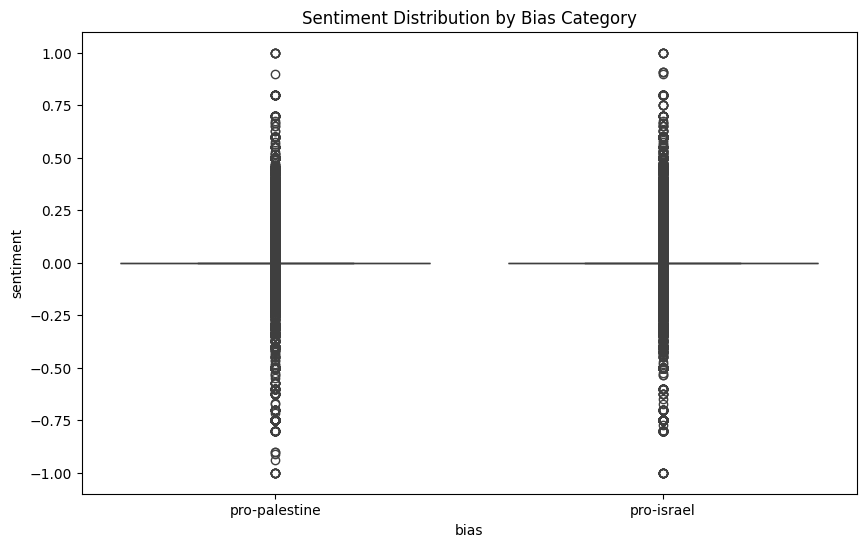

<Figure size 1400x600 with 0 Axes>

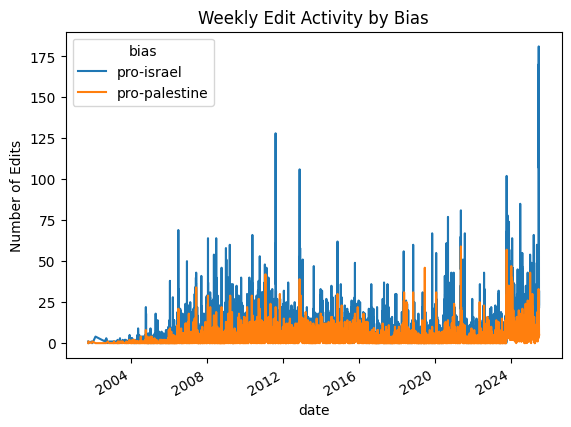

Most Controversial Pages:
                                              score
page                                               
Palestine Liberation Organization          0.700688
1948 Palestinian expulsion and flight      0.641804
Land of Israel                             0.616484
Arab–Israeli conflict                      0.533978
Palestinian Authority                      0.533142
Occupied Palestinian territories           0.532354
East Jerusalem                             0.528859
Tel Aviv–Jerusalem bus 405 suicide attack  0.525000
Gaza City                                  0.495840
Palestinian refugees                       0.486893


In [21]:
# 1. Sentiment vs. Bias
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='bias', y='sentiment')
plt.title("Sentiment Distribution by Bias Category")
plt.show()

# 2. Temporal Trends
# Ensure the date is in proper datetime format
df['date'] = pd.to_datetime(df['timestamp'].dt.date)
weekly_trends = df.groupby(['date', 'bias']).size().unstack().fillna(0)

# Convert the index to datetime if it's not already
weekly_trends.index = pd.to_datetime(weekly_trends.index)

plt.figure(figsize=(14,6))
weekly_trends.plot()
plt.title("Weekly Edit Activity by Bias")
plt.ylabel("Number of Edits")
plt.show()

# Controversy calculation
controversy = df.groupby('page').agg({
    'user': 'nunique',
    'edit_type': lambda x: (x == 'revert').sum(),
    'sentiment': 'mean',
    'bias': lambda x: (x != 'neutral').mean()
})

# Normalize and compute the controversy score
controversy['score'] = (
    0.4 * controversy['edit_type'] / controversy['edit_type'].max() +
    0.3 * abs(controversy['sentiment']) +
    0.3 * controversy['bias']
)

print("Most Controversial Pages:")
print(controversy.sort_values('score', ascending=False)[['score']].head(10))

In [22]:
print("Original DataFrame shape:", df.shape)
print("Columns:", df.columns)
print("Unique bias values:", df['bias'].unique())
print("Date range:", df['timestamp'].min(), df['timestamp'].max())

Original DataFrame shape: (93321, 15)
Columns: Index(['page', 'user', 'timestamp', 'comment', 'size', 'revid', 'is_bot',
       'bias', 'size_diff', 'edit_type', 'urgent', 'sentiment',
       'sentiment_category', 'date', 'time_since_last'],
      dtype='object')
Unique bias values: ['pro-palestine' 'pro-israel']
Date range: 2001-10-08 13:13:04 2025-06-29 19:26:32


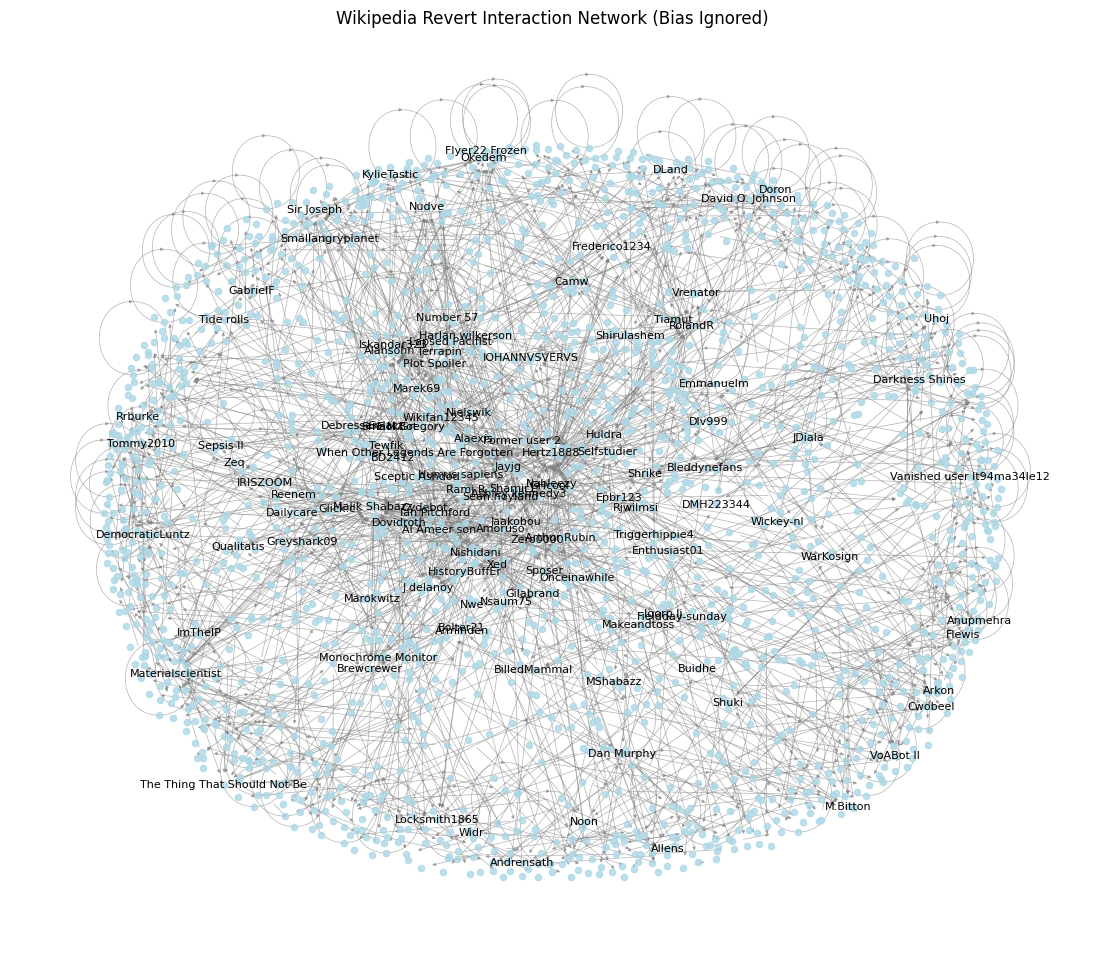


Network Statistics:
- Total editors: 2013
- Total revert interactions: 1911
- Most active reverting editor: ('Zero0000', 19)
- Most reverted editor: ('Hertz1888', 64)

Top Revert Relationships:
Hertz1888 was reverted by Hertz1888 (12 times)
IOHANNVSVERVS was reverted by IOHANNVSVERVS (9 times)
Nableezy was reverted by Nableezy (7 times)
Flawfixer was reverted by N5iln (7 times)
Jayjg was reverted by Jayjg (5 times)
Community 0: 2 editors
Community 1: 3 editors
Community 2: 2 editors
Community 3: 2 editors
Community 4: 2 editors
Community 5: 100 editors
Community 6: 4 editors
Community 7: 2 editors
Community 8: 3 editors
Community 9: 2 editors
Community 10: 3 editors
Community 11: 2 editors
Community 12: 2 editors
Community 13: 2 editors
Community 14: 2 editors
Community 15: 53 editors
Community 16: 1 editors
Community 17: 8 editors
Community 18: 2 editors
Community 19: 1 editors
Community 20: 2 editors
Community 21: 3 editors
Community 22: 2 editors
Community 23: 4 editors
Community 2

In [23]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import networkx.algorithms.community as nx_comm


# Build pure interaction network (ignoring bias)
G = nx.DiGraph()  # Using directed graph to show who reverted whom
reverts = df[df['edit_type'] == 'revert']

for _, row in reverts.iterrows():
    # Find the immediately preceding edit on the same page
    prev_edit = df[(df['page'] == row['page']) & 
                  (df['timestamp'] < row['timestamp'])].tail(1)
    
    if not prev_edit.empty:
        prev_editor = prev_edit.iloc[0]['user']
        current_editor = row['user']
        
        if pd.notna(prev_editor) and pd.notna(current_editor):
            # Add edge (direction: prev_editor → current_editor, meaning current reverted prev)
            if G.has_edge(prev_editor, current_editor):
                G[prev_editor][current_editor]['weight'] += 1
            else:
                G.add_edge(prev_editor, current_editor, weight=1)

# Visualize
plt.figure(figsize=(14, 12))
pos = nx.spring_layout(G, k=0.15, iterations=50)

# Draw nodes and edges
nx.draw_networkx_nodes(G, pos, node_size=20, alpha=0.8, node_color='lightblue')
nx.draw_networkx_edges(G, pos, 
                      edge_color='gray', 
                      width=0.5, 
                      alpha=0.6,
                      arrowsize=5)

# Label only frequent interactors
degree_threshold = 5
important_nodes = [node for node, degree in dict(G.degree()).items() if degree >= degree_threshold]
labels = {node: node for node in important_nodes}
nx.draw_networkx_labels(G, pos, labels, font_size=8)

plt.title('Wikipedia Revert Interaction Network (Bias Ignored)')
plt.axis('off')  # Turn off axis
plt.show()

# Print basic network stats
print("\nNetwork Statistics:")
print(f"- Total editors: {G.number_of_nodes()}")
print(f"- Total revert interactions: {G.number_of_edges()}")
print(f"- Most active reverting editor: {max(dict(G.out_degree()).items(), key=lambda x: x[1])}")
print(f"- Most reverted editor: {max(dict(G.in_degree()).items(), key=lambda x: x[1])}")

# Show strongest connections (edges with highest weights)
print("\nTop Revert Relationships:")
sorted_edges = sorted(G.edges(data=True), key=lambda x: x[2].get('weight', 0), reverse=True)[:5]
for u, v, d in sorted_edges:
    print(f"{u} was reverted by {v} ({d['weight']} times)")


communities = nx_comm.louvain_communities(G)
for idx, comm in enumerate(communities):
    print(f"Community {idx}: {len(comm)} editors")

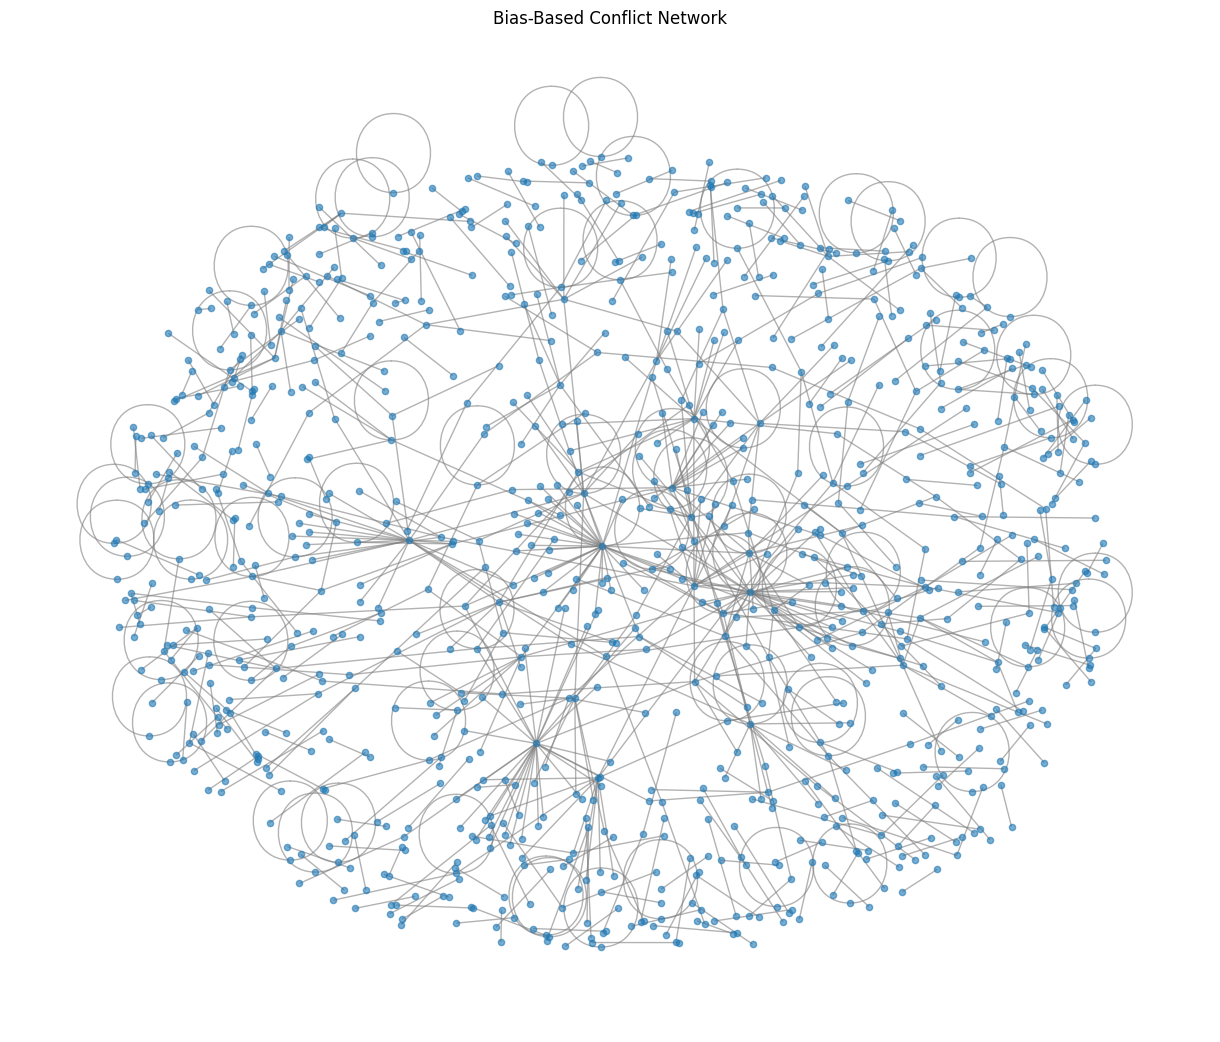

Community 0: 35 editors
Community 1: 2 editors
Community 2: 11 editors
Community 3: 1 editors
Community 4: 2 editors
Community 5: 2 editors
Community 6: 2 editors
Community 7: 2 editors
Community 8: 5 editors
Community 9: 32 editors
Community 10: 2 editors
Community 11: 15 editors
Community 12: 29 editors
Community 13: 2 editors
Community 14: 2 editors
Community 15: 2 editors
Community 16: 2 editors
Community 17: 3 editors
Community 18: 2 editors
Community 19: 6 editors
Community 20: 2 editors
Community 21: 2 editors
Community 22: 1 editors
Community 23: 40 editors
Community 24: 3 editors
Community 25: 1 editors
Community 26: 3 editors
Community 27: 2 editors
Community 28: 2 editors
Community 29: 2 editors
Community 30: 2 editors
Community 31: 2 editors
Community 32: 2 editors
Community 33: 2 editors
Community 34: 2 editors
Community 35: 2 editors
Community 36: 1 editors
Community 37: 4 editors
Community 38: 2 editors
Community 39: 1 editors
Community 40: 7 editors
Community 41: 2 edit

In [24]:
# Build bias interaction network
G = nx.Graph()
reverts = df[df['edit_type'] == 'revert']

for _, row in reverts.iterrows():
    prev_edits = df[(df['page'] == row['page']) & 
                   (df['timestamp'] < row['timestamp'])]
    if not prev_edits.empty:
        prev_editor = prev_edits.iloc[-1]['user']
        if pd.notna(prev_editor):
            # Only connect editors with opposing biases
            if (row['bias'] != 'neutral') and (prev_edits.iloc[-1]['bias'] != 'neutral'):
                if row['bias'] != prev_edits.iloc[-1]['bias']:
                    G.add_edge(prev_editor, row['user'], 
                              conflict_type=f"{prev_edits.iloc[-1]['bias']}_vs_{row['bias']}")

# Visualize
plt.figure(figsize=(12,10))
pos = nx.spring_layout(G, k=0.15)
nx.draw(G, pos, node_size=20, alpha=0.6, edge_color='gray')
plt.title('Bias-Based Conflict Network')
plt.show()

communities = nx_comm.louvain_communities(G)
for idx, comm in enumerate(communities):
    print(f"Community {idx}: {len(comm)} editors")

In [25]:
df['time_since_last'] = df.groupby('page')['timestamp'].diff().dt.total_seconds()/60
edit_wars = df[(df['edit_type']=='revert') & (df['time_since_last']<15)]
print(f"Detected {len(edit_wars)} potential edit wars")

Detected 581 potential edit wars


C:\Users\USER\AppData\Local\Temp\ipykernel_11196\2501625935.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(key='timestamp', freq='M'), 'bias']


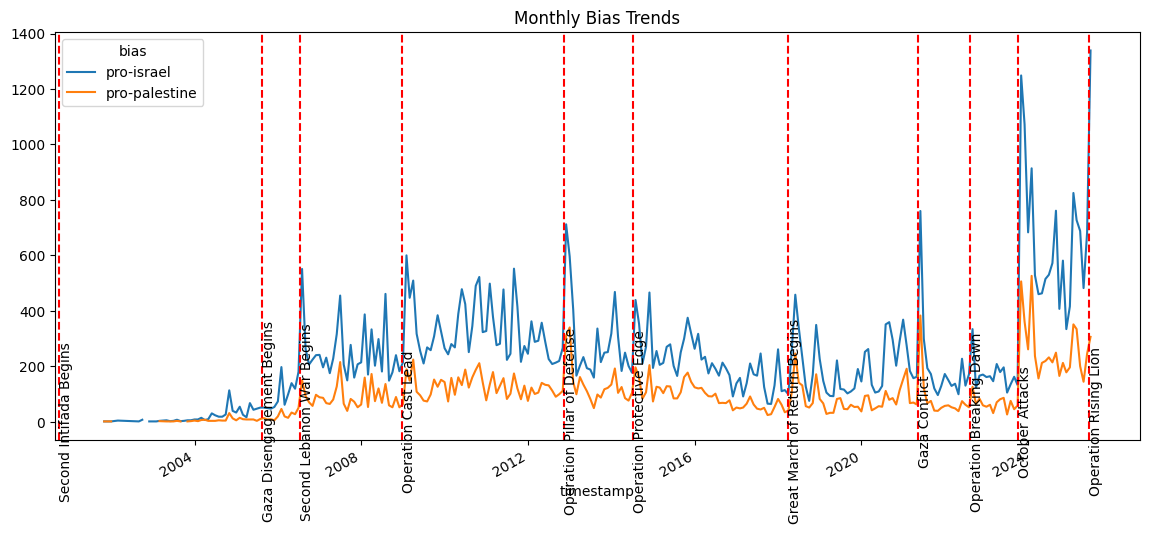

In [26]:
monthly_bias = df[df['bias']!='neutral'].groupby(
    [pd.Grouper(key='timestamp', freq='M'), 'bias']
).size().unstack()
monthly_bias.plot(kind='line', stacked=False, figsize=(14, 6))
plt.title("Monthly Bias Trends")

important_events = {
    "2000-09-28": "Second Intifada Begins",
    "2005-08-15": "Gaza Disengagement Begins",
    "2006-07-12": "Second Lebanon War Begins",
    "2008-12-27": "Operation Cast Lead",
    "2012-11-14": "Operation Pillar of Defense",
    "2014-07-08": "Operation Protective Edge",
    "2018-03-30": "Great March of Return Begins",
    "2021-05-10": "Gaza Conflict",
    "2022-08-05": "Operation Breaking Dawn",
    "2023-10-07": "October Attacks",
    "2025-06-13": "Operation Rising Lion"
}

for date, label in important_events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--')
    plt.text(pd.to_datetime(date), 0.9, label, rotation=90, verticalalignment='center')

plt.show()

C:\Users\USER\AppData\Local\Temp\ipykernel_11196\809005945.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  [pd.Grouper(key='timestamp', freq='M'), 'bias']


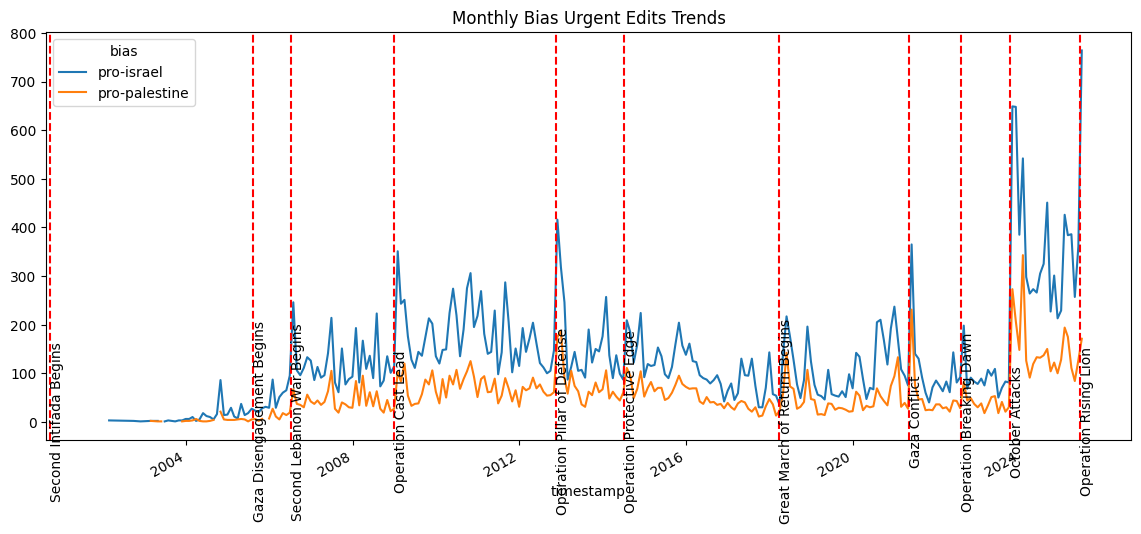

In [27]:
urgent_edits = df[df['urgent']]

monthly_bias = urgent_edits[urgent_edits['bias']!='neutral'].groupby(
    [pd.Grouper(key='timestamp', freq='M'), 'bias']
).size().unstack()
monthly_bias.plot(kind='line', stacked=False, figsize=(14, 6))
plt.title("Monthly Bias Urgent Edits Trends")

for date, label in important_events.items():
    plt.axvline(pd.to_datetime(date), color='red', linestyle='--')
    plt.text(pd.to_datetime(date), 0.9, label, rotation=90, verticalalignment='center')

plt.show()

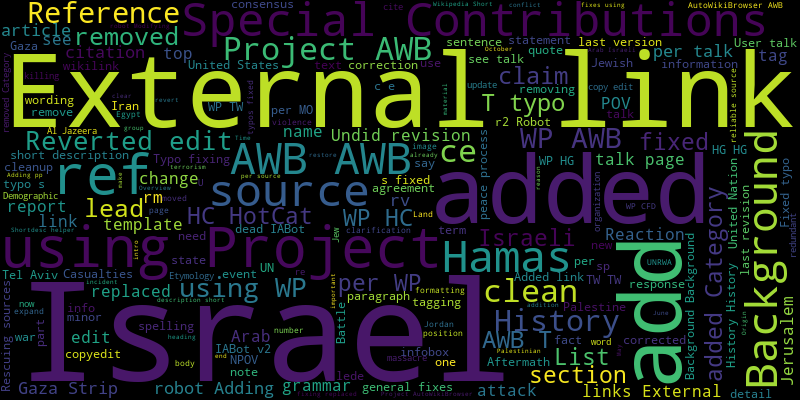

In [28]:
from wordcloud import WordCloud

pro_israel_text = ' '.join(df[df['bias'] == 'pro-israel']['comment'])
WordCloud(width=800, height=400).generate(pro_israel_text).to_image()

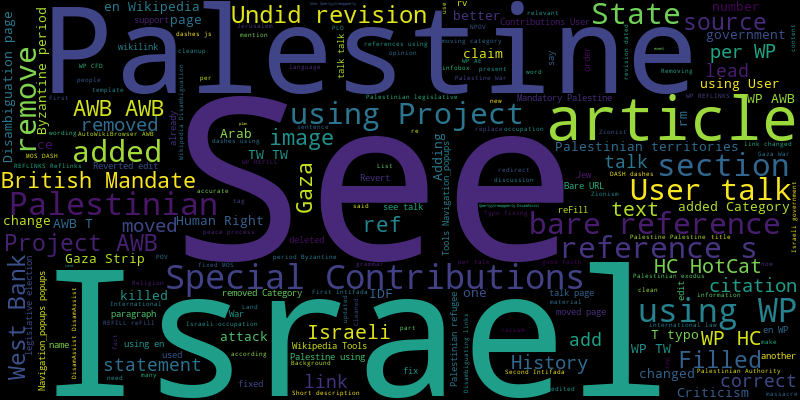

In [29]:
from wordcloud import WordCloud

pro_israel_text = ' '.join(df[df['bias'] == 'pro-palestine']['comment'])
WordCloud(width=800, height=400).generate(pro_israel_text).to_image()